In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
config_df = pd.read_csv("config.csv")
epoch_df = pd.read_csv("epoch.csv")
epoch_df.head()
config_df.head()

,config_id,model_type,model_name,pooling_type,epochs,dropout
0,1,sbert,sentence-transformers/distiluse-base-multiling...,cls,7,0.1
1,2,mbert,google-bert/bert-base-multilingual-cased,cls,7,0.5
2,13,bert,indobenchmark/indobert-lite-base-p2,cls,11,0.3


# Training Plot

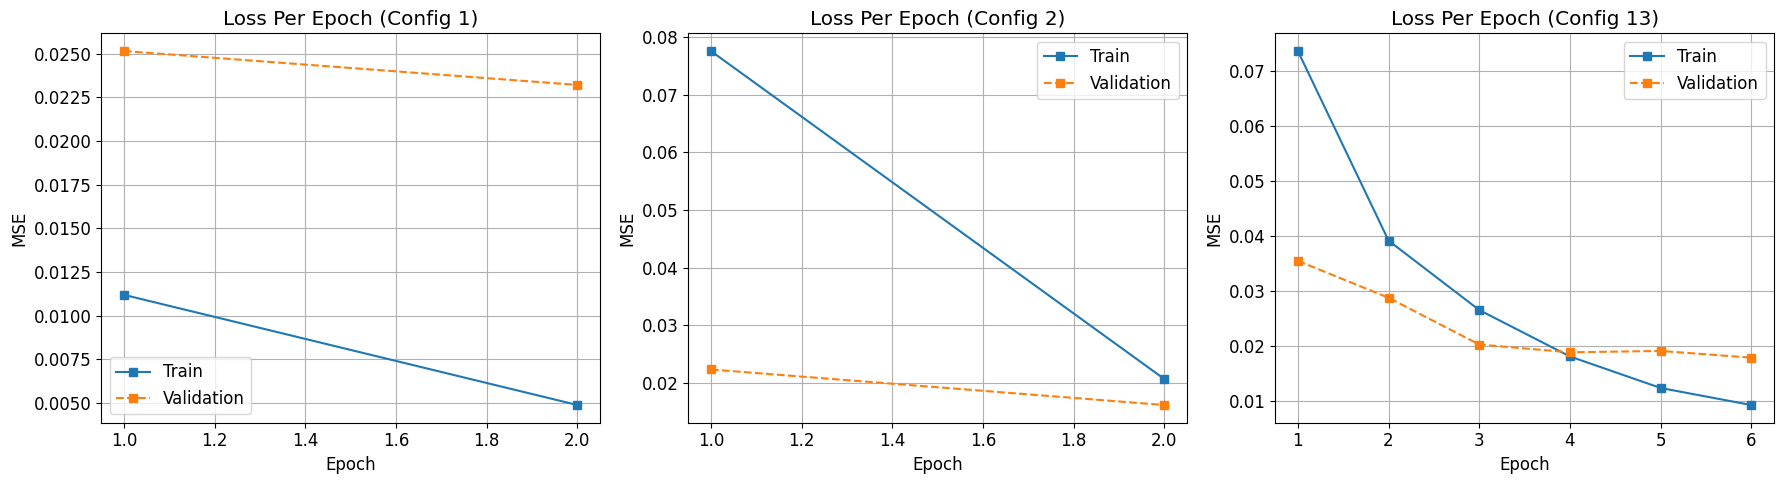

In [20]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [21]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer, AutoTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset as AutomaticScoringDatasetBert
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib
from main_similarity import SiameseModel, AutomaticScoringDataset as AutomaticScoringDatasetSBert

def predict_bert(df_test, config_id, model, tokenizer):
    test_data = AutomaticScoringDatasetBert(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/best_model/cross/model_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

tokenizerSBert = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")
def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict_sbert(df_test, config_id, model):
    test_data = AutomaticScoringDatasetSBert(df_test, tokenizerSBert)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    
    checkpoint = torch.load(f"../../../models/best_model/cross/model_{config_id}.pt", map_location='cuda', weights_only=True)
    reg_model = joblib.load(f"../../../models/best_model/cross/reg_{config_id}.pkl")
    model.load_state_dict(checkpoint)
    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [22]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in config_df.itertuples():
    if row.model_type == "bert" or row.model_type == "mbert":
        tokenizer = BertTokenizer.from_pretrained(row.model_name)
        model = RegressionModel(row.model_name, pooling_type=row.pooling_type).to('cuda')
        all_predictions, all_targets = predict_bert(df_test, row.config_id, model, tokenizer)
    else:
        model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2", pooling_type=row.pooling_type).to('cuda')
        all_predictions, all_targets = predict_sbert(df_test, row.config_id, model)

    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "result1.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initial


>> Similarity-Based Scoring
RMSE: 0.1238, Pearson: 0.8766

>> Direct Scoring (mBERT)
RMSE: 0.0986, Pearson: 0.9249

>> Direct Scoring (IndoBERT)
RMSE: 0.0937, Pearson: 0.9258


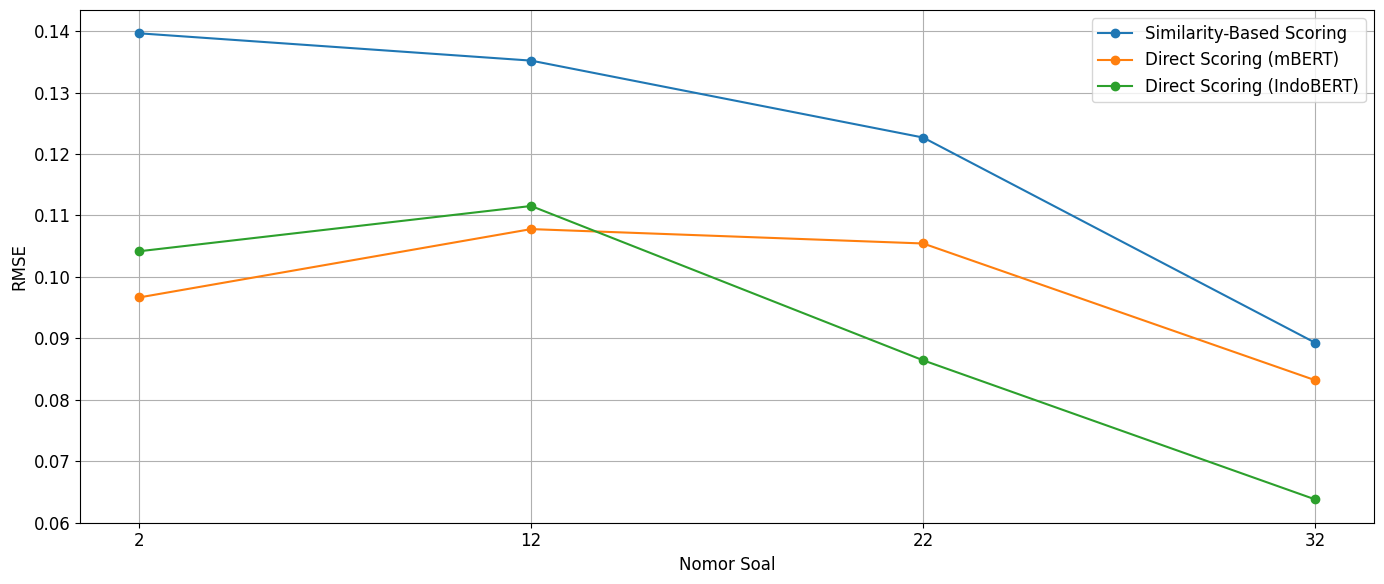

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("1.csv")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_1": "Similarity-Based Scoring",
    "predicted_score_2": "Direct Scoring (mBERT)",
    "predicted_score_13": "Direct Scoring (IndoBERT)",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique())) 
plt.tight_layout()
plt.show()




>> Similarity-Based Scoring
Pearson: 0.8766

>> Direct Scoring (mBERT)
Pearson: 0.9249

>> Direct Scoring (IndoBERT)
Pearson: 0.9258


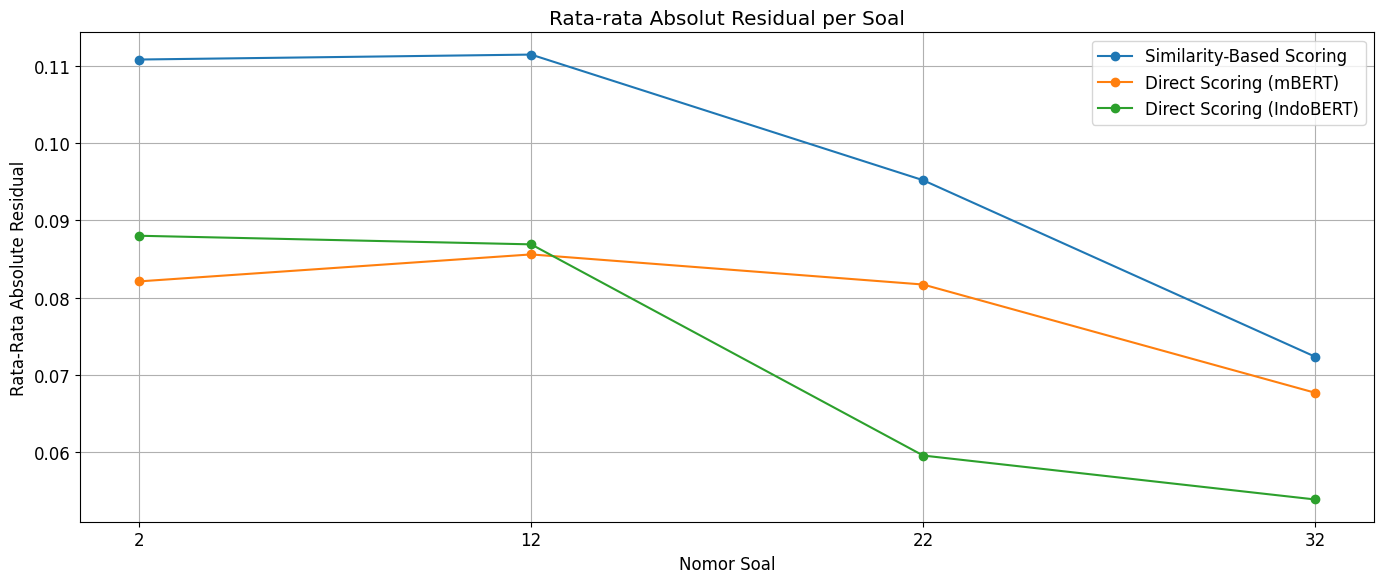

{
    "Similarity-Based Scoring": {
        "2": 0.11078981292982455,
        "12": 0.1114298125490196,
        "22": 0.09517497489795919,
        "32": 0.07234104850980393
    },
    "Direct Scoring (mBERT)": {
        "2": 0.08208775533333332,
        "12": 0.08557773843137255,
        "22": 0.08168289000000001,
        "32": 0.06767860735294118
    },
    "Direct Scoring (IndoBERT)": {
        "2": 0.08799238522807015,
        "12": 0.08687933815686275,
        "22": 0.059560766836734697,
        "32": 0.05387564145098039
    }
}


In [32]:
import json
absolute_residual_per_model = {}
metric_eval_data = {}

model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = np.abs(pred_scores - true_scores) 

        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label}")
        print(f"Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "Pearson": round(pearson, 4)
        }

        avg_absolute_residual_per_soal = df.groupby('dataset_num').apply(lambda x: np.mean(np.abs(x[col] - x['normalized_score'])), include_groups=False)
        absolute_residual_per_model[label] = avg_absolute_residual_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
absolute_residual_json = {}
for i, label in enumerate(absolute_residual_per_model):
    absolute_residual_series = absolute_residual_per_model[label]
    
    soal_numbers = extract_soal_number(absolute_residual_series.index)
    
    absolute_residual_series.index = soal_numbers
    absolute_residual_series = absolute_residual_series.sort_index()
    
    plt.plot(absolute_residual_series.index, absolute_residual_series.values, marker='o', linestyle='-', label=label)
    absolute_residual_json[label] = {
        str(soal): float(residual) for soal, residual in absolute_residual_series.items()
    }

plt.title("Rata-rata Absolut Residual per Soal")
plt.xlabel("Nomor Soal")
plt.ylabel("Rata-Rata Absolute Residual")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(absolute_residual_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()

print(json.dumps(absolute_residual_json, indent=4))

In [25]:
import os
import numpy as np
import pandas as pd

thresholds = [0.1, 0.2]
model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [c for c in df.columns if c.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values

        abs_residuals = np.abs(pred_scores - true_scores)

        q1 = np.percentile(abs_residuals, 25)
        q3 = np.percentile(abs_residuals, 75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr

        outlier_iqr_mask = abs_residuals > upper_bound
        num_outliers_iqr = np.sum(outlier_iqr_mask)

        label = label_map.get(col, col)
        model_data.append({
            "label": label,
            "q1": q1,
            "q3": q3,
            "upper_bound": upper_bound,
            "num_outliers_iqr": num_outliers_iqr,
            "abs_residuals": abs_residuals
        })

outlier_count = {}
for model in sorted(model_data, key=lambda x: x["label"]):
    label = model["label"]
    abs_residuals = model["abs_residuals"]

    print(f"{label}:")
    print(f"  Q1       : {model['q1']:.4f}")
    print(f"  Q3       : {model['q3']:.4f}")
    print(f"  Upper bd : {model['upper_bound']:.4f}")
    print(f"  Outlier (IQR)       : {model['num_outliers_iqr']}")

    outlier_summary = {
        "IQR": model['num_outliers_iqr']
    }

    for t in thresholds:
        num_out = np.sum(abs_residuals > t)
        outlier_summary[f"Fixed {t}"] = num_out
        print(f"  Outlier (Fixed {t}) : {num_out}")

    print()
    outlier_count[label] = outlier_summary


Direct Scoring (IndoBERT):
  Q1       : 0.0303
  Q3       : 0.0980
  Upper bd : 0.1995
  Outlier (IQR)       : 7
  Outlier (Fixed 0.1) : 51
  Outlier (Fixed 0.2) : 7

Direct Scoring (mBERT):
  Q1       : 0.0345
  Q3       : 0.1125
  Upper bd : 0.2296
  Outlier (IQR)       : 5
  Outlier (Fixed 0.1) : 65
  Outlier (Fixed 0.2) : 9

Similarity-Based Scoring:
  Q1       : 0.0374
  Q3       : 0.1410
  Upper bd : 0.2962
  Outlier (IQR)       : 3
  Outlier (Fixed 0.1) : 88
  Outlier (Fixed 0.2) : 19



C:\Users\User\AppData\Local\Temp\ipykernel_25220\2352631345.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(residuals_list, labels=labels, patch_artist=True, showfliers=True)


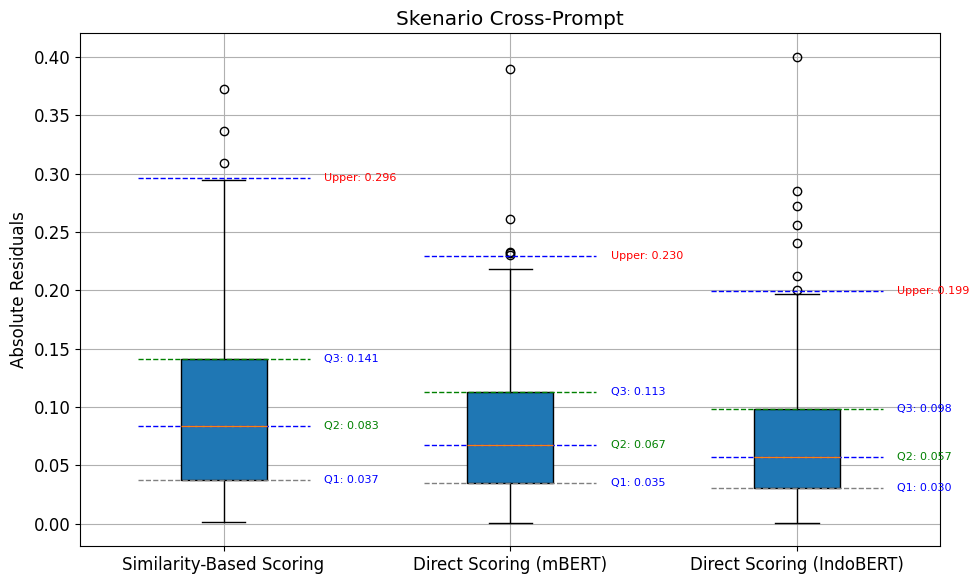

In [26]:
import matplotlib.pyplot as plt


residuals_list = [model["abs_residuals"] for model in model_data]
labels = [model["label"] for model in model_data]

fig, ax = plt.subplots(figsize=(10, 6))
box = ax.boxplot(residuals_list, labels=labels, patch_artist=True, showfliers=True)

for i, model in enumerate(model_data):
    q1 = model['q1']
    q3 = model['q3']
    iqr = q3 - q1
    median = np.median(model['abs_residuals'])
    upper_bound = q3 + 1.5 * iqr

    xpos = i + 1
    
    ax.hlines([q1, median, q3, upper_bound], 
              xmin=xpos - 0.3, xmax=xpos + 0.3, 
              colors=["gray", "blue", "green", "blue", "red"], 
              linestyles='--', linewidth=1)

    ax.text(xpos + 0.35, q1, f"Q1: {q1:.3f}", va='center', fontsize=8, color='blue')
    ax.text(xpos + 0.35, median, f"Q2: {median:.3f}", va='center', fontsize=8, color='green')
    ax.text(xpos + 0.35, q3, f"Q3: {q3:.3f}", va='center', fontsize=8, color='blue')
    ax.text(xpos + 0.35, upper_bound, f"Upper: {upper_bound:.3f}", va='center', fontsize=8, color='red')

ax.set_ylabel("Absolute Residuals")
ax.set_title("Skenario Cross-Prompt")
ax.grid(True)
plt.tight_layout()
plt.show()


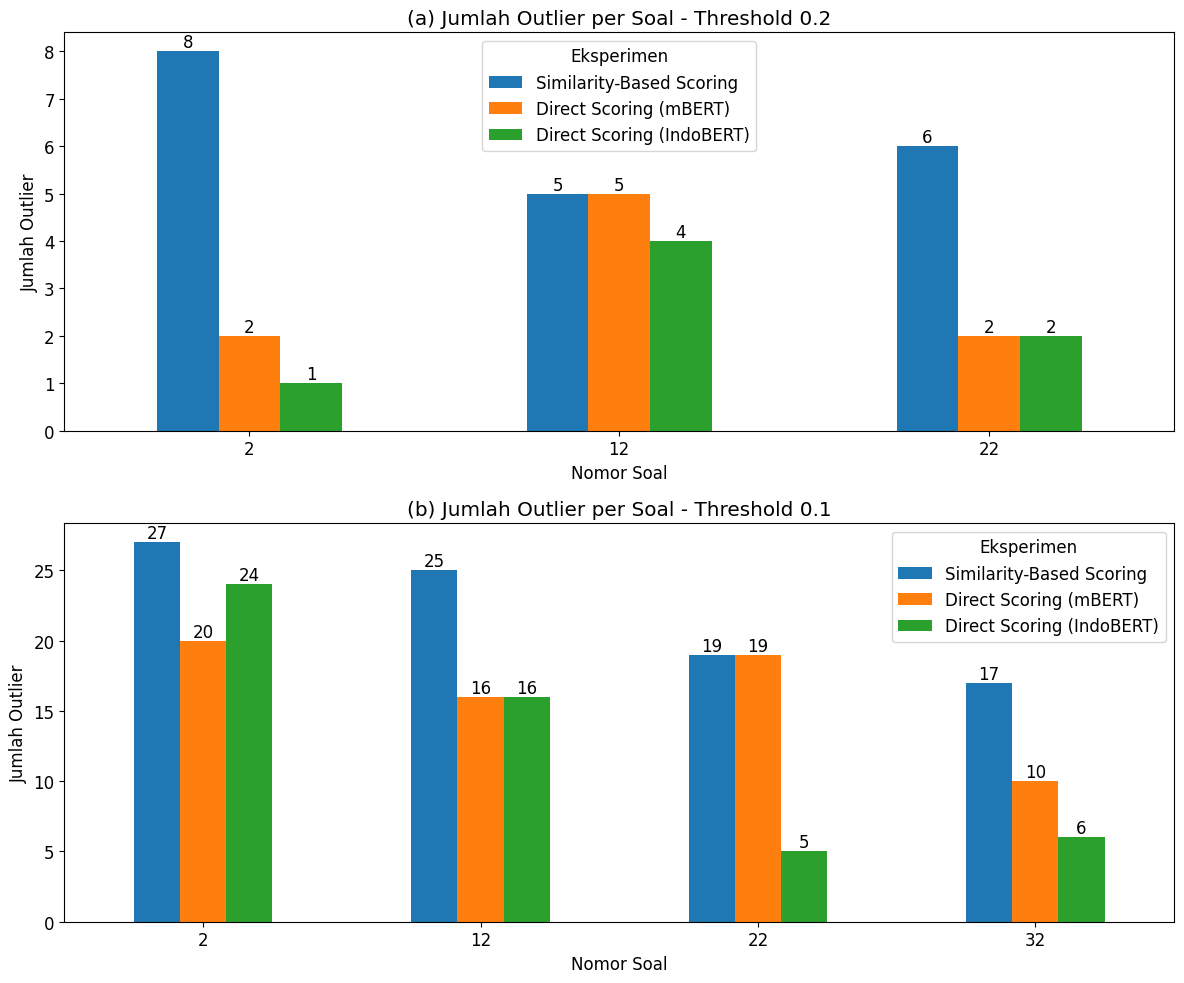

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

outlier_counts_fixed2 = {}
outlier_counts_fixed1 = {}

fixed_threshold2 = 0.2
fixed_threshold1 = 0.1

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_fixed2 = np.abs(residuals) > fixed_threshold2
        outlier_mask_fixed1 = np.abs(residuals) > fixed_threshold1

        df['outlier_fixed2'] = outlier_mask_fixed2
        df['outlier_fixed1'] = outlier_mask_fixed1

        label = label_map.get(col, col)

        fixed_counts2 = df[df['outlier_fixed2']].groupby('soal_num').size()
        outlier_counts_fixed2[label] = fixed_counts2

        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()
df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

df_fixed2.plot(kind='bar', ax=ax1)
ax1.set_title("(a) Jumlah Outlier per Soal - Threshold 0.2")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)

for container in ax1.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

df_fixed1.plot(kind='bar', ax=ax2)
ax2.set_title("(b) Jumlah Outlier per Soal - Threshold 0.1")
ax2.set_xlabel("Nomor Soal")
ax2.set_ylabel("Jumlah Outlier")
ax2.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax2.tick_params(axis='x', rotation=0, labelsize=12)

for container in ax2.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

plt.tight_layout()
plt.show()




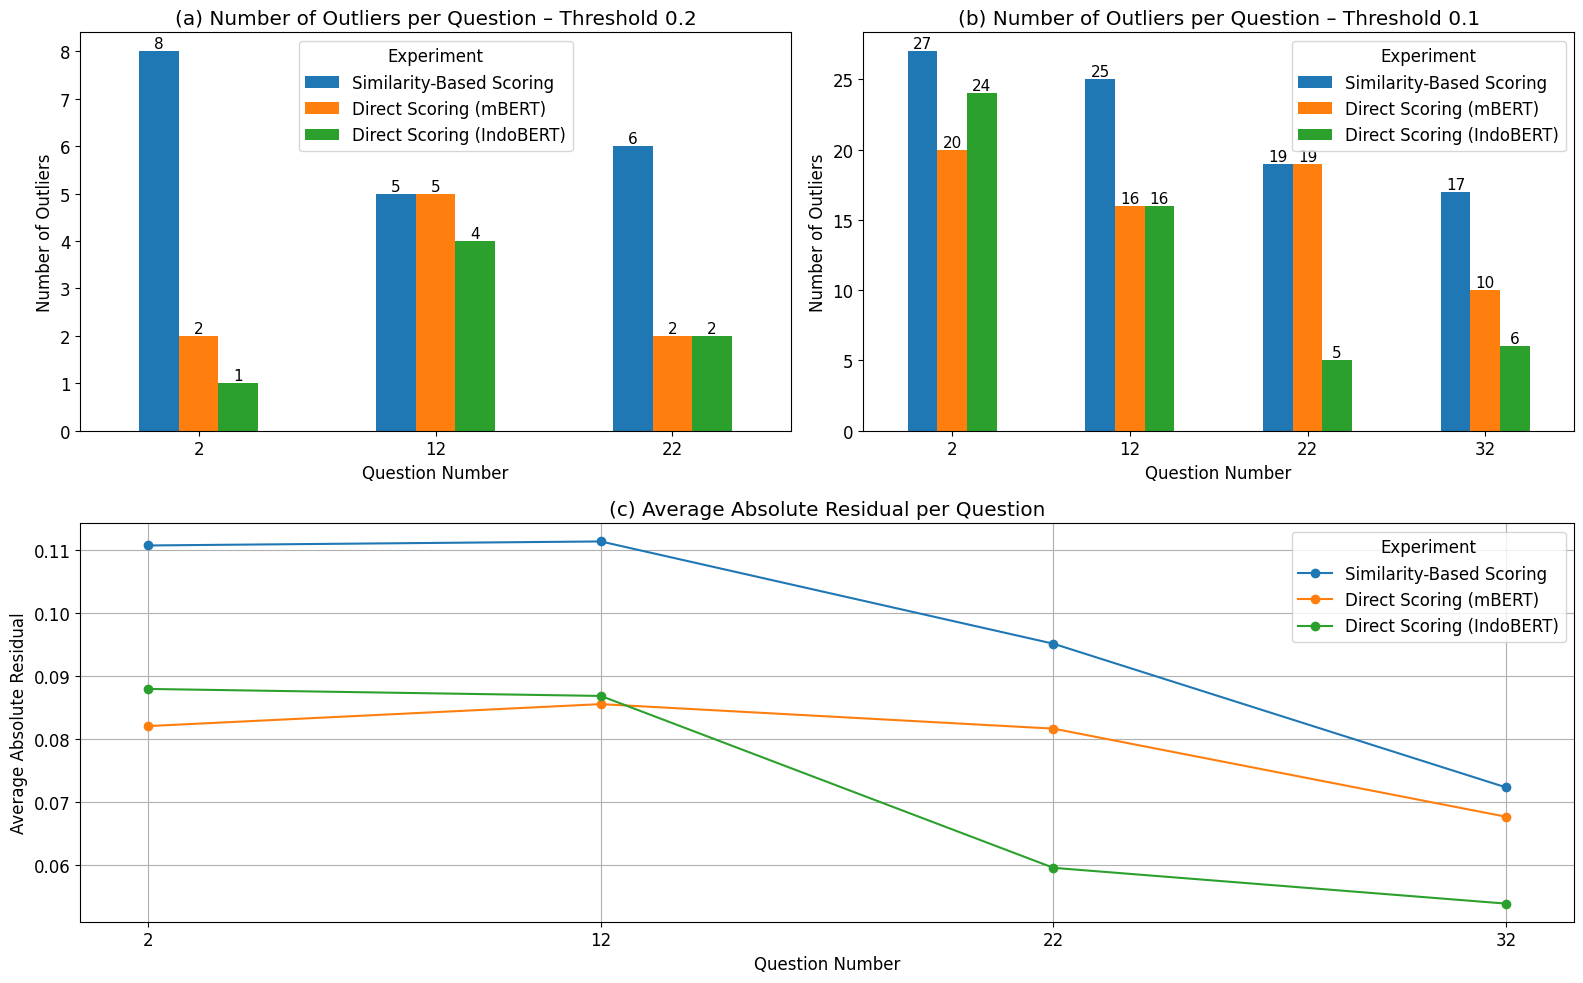

{
    "Similarity-Based Scoring": {
        "0": 12.0,
        "1": 2.0,
        "2": 22.0,
        "3": 32.0
    },
    "Direct Scoring (mBERT)": {
        "0": 12.0,
        "1": 2.0,
        "2": 22.0,
        "3": 32.0
    },
    "Direct Scoring (IndoBERT)": {
        "0": 12.0,
        "1": 2.0,
        "2": 22.0,
        "3": 32.0
    }
}


In [28]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

outlier_counts_fixed2, outlier_counts_fixed1 = {}, {}
fixed_threshold2, fixed_threshold1 = 0.2, 0.1

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [c for c in df.columns if c.startswith('predicted_score_')]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        resid = df[col].values - true_scores
        df['outlier_fixed2'] = np.abs(resid) > fixed_threshold2
        df['outlier_fixed1'] = np.abs(resid) > fixed_threshold1
        lbl = label_map.get(col, col)

        outlier_counts_fixed2[lbl] = df[df.outlier_fixed2].groupby('soal_num').size()
        outlier_counts_fixed1[lbl] = df[df.outlier_fixed1].groupby('soal_num').size()

df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()
df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()

absolute_residual_per_model, absolute_residual_json = {}, {}
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [c for c in df.columns if c.startswith('predicted_score_')]

    for col in pred_cols:
        lbl = label_map.get(col, col)
        avg_abs_resid = df.groupby('dataset_num').apply(
            lambda x: np.mean(np.abs(x[col] - x['normalized_score'])),
            include_groups=False
        )
        absolute_residual_per_model[lbl] = avg_abs_resid

plt.rcParams.update({'font.size': 12})

fig, axd = plt.subplot_mosaic(
    [['left', 'right'],    
     ['bottom', 'bottom']], 
    figsize=(16, 10)
)

ax1, ax2, ax3 = axd['left'], axd['right'], axd['bottom']

df_fixed2.plot(kind='bar', ax=ax1)
ax1.set_title("(a) Number of Outliers per Question – Threshold 0.2")
ax1.set_xlabel("Question Number")
ax1.set_ylabel("Number of Outliers")
ax1.legend(title="Experiment", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0)

for cont in ax1.containers:
    for b in cont:
        h = b.get_height()
        if h: 
            ax1.text(b.get_x() + b.get_width() / 2, h, f'{int(h)}',
                     ha='center', va='bottom', fontsize=11)

df_fixed1.plot(kind='bar', ax=ax2)
ax2.set_title("(b) Number of Outliers per Question – Threshold 0.1")
ax2.set_xlabel("Question Number")
ax2.set_ylabel("Number of Outliers")
ax2.legend(title="Experiment", fontsize=12, title_fontsize=12)
ax2.tick_params(axis='x', rotation=0)

for cont in ax2.containers:
    for b in cont:
        h = b.get_height()
        if h: 
            ax2.text(b.get_x() + b.get_width() / 2, h, f'{int(h)}',
                     ha='center', va='bottom', fontsize=11)

def extract_num(idx):
    return idx.astype(str).str.extract(r'(\d+)$').astype(int)[0]

for lbl, ser in absolute_residual_per_model.items():
    ser = ser.copy()
    ser.index = extract_num(ser.index)
    ser = ser.sort_index()
    ax3.plot(ser.index, ser.values, marker='o', label=lbl)

ax3.set_title("(c) Average Absolute Residual per Question")
ax3.set_xlabel("Question Number")
ax3.set_ylabel("Average Absolute Residual")
ax3.grid(True)
ax3.legend(title="Experiment", fontsize=12, title_fontsize=12)
ax3.set_xticks(sorted(ser.index.unique()))


fig.tight_layout()
plt.show()

print(json.dumps({
    lbl: {str(k): float(v) for k, v in extract_num(ser.index).items()}
    for lbl, ser in absolute_residual_per_model.items()
}, indent=4))


In [41]:
print("Metrik Evaluation")
print(metric_eval_data)
print("Jumlah Outlier Per Metode IQR")
print(outlier_count)
print("Jumlah Outlier Per Soal Metode Fixed Threshold +-0.1 (key = nomor soal, value = jumlah outlier)")
print(df_fixed1.to_json())
print("Jumlah Outlier Per Soal Metode Fixed Threshold +-0.2 (key = nomor soal, value = jumlah outlier)")
print(df_fixed2.to_json())

Metrik Evaluation
{'Similarity-Based Scoring': {'Pearson': 0.8766}, 'Direct Scoring (mBERT)': {'Pearson': 0.9249}, 'Direct Scoring (IndoBERT)': {'Pearson': 0.9258}}
Jumlah Outlier Per Metode IQR
{'Direct Scoring (IndoBERT)': {'IQR': 7, 'Fixed 0.1': 51, 'Fixed 0.2': 7}, 'Direct Scoring (mBERT)': {'IQR': 5, 'Fixed 0.1': 65, 'Fixed 0.2': 9}, 'Similarity-Based Scoring': {'IQR': 3, 'Fixed 0.1': 88, 'Fixed 0.2': 19}}
Jumlah Outlier Per Soal Metode Fixed Threshold +-0.1 (key = nomor soal, value = jumlah outlier)
{"Similarity-Based Scoring":{"2":27,"12":25,"22":19,"32":17},"Direct Scoring (mBERT)":{"2":20,"12":16,"22":19,"32":10},"Direct Scoring (IndoBERT)":{"2":24,"12":16,"22":5,"32":6}}
Jumlah Outlier Per Soal Metode Fixed Threshold +-0.2 (key = nomor soal, value = jumlah outlier)
{"Similarity-Based Scoring":{"2":8,"12":5,"22":6},"Direct Scoring (mBERT)":{"2":2,"12":5,"22":2},"Direct Scoring (IndoBERT)":{"2":1,"12":4,"22":2}}


# Worst On Both

In [40]:
import json
import os
import pandas as pd

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("1.csv")]

interesting_num = [22]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_1', 'predicted_score_2', 'predicted_score_13']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_indobert'] = subset_iqr.apply(lambda x: abs(x['predicted_score_13'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_mbert'] = subset_iqr.apply(lambda x: abs(x['predicted_score_2'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_1": "predicted_score_similarity", "predicted_score_13": "predicted_score_indobert", "predicted_score_2": "predicted_score_mbert"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_indobert', 'residual_indobert','predicted_score_mbert', 'residual_mbert']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    subset_iqr1 = subset_iqr[(subset_iqr['residual_similarity'] < 0.05) & (subset_iqr['residual_indobert'] > 0.05) & (subset_iqr['residual_mbert'] > 0.05)]
    print(subset_iqr1.to_json(orient="records", indent=2, force_ascii=False))

[
  {
    "soal_num":22,
    "question":"Tuliskan isi teks asli proklamasi dengan ejaan yang telah disempurnakan. ",
    "reference_answer":"proklamasi kami bangsa indonesia dengan ini menyatakan kemerdekaan indonesia hal hal yang mengenai pemindahan kekuasaan d l l diselenggarakan dengan cara seksama dan dalam tempo yang sesingkat singkatnya jakarta 17 8 05 wakil wakil bangsa indonesia",
    "answer":"proklamasi kami bangsa indonesia dengan ini menyatakan kemerdekaan indonesia hal hal yang mengenai pemindahan kekuasaan dan lain lain diselenggarakan dengan cara seksama dan dalam tempo yang sesingkat singkatnya jakarta har 17 bulan 8 tahun 05 atas nama bangsa indonesia soekarno hatta",
    "normalized_score":0.78,
    "predicted_score_similarity":0.7828939,
    "residual_similarity":0.0028939,
    "predicted_score_indobert":0.84131396,
    "residual_indobert":0.06131396,
    "predicted_score_mbert":0.8977067,
    "residual_mbert":0.1177067
  },
  {
    "soal_num":22,
    "question":"Tul

In [ ]:
import json
import os
import pandas as pd

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("1.csv")]

interesting_num = [22]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_1', 'predicted_score_10']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_10'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_1": "predicted_score_similarity", "predicted_score_10": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    subset_iqr1 = subset_iqr[(subset_iqr['residual_similarity'] > 0.1) & (subset_iqr['residual_direct'] < 0.02)]
    print(subset_iqr1.to_json(orient="records", indent=2, force_ascii=False))
    subset_iqr2 = subset_iqr[(subset_iqr['residual_similarity'] < 0.05) & (subset_iqr['residual_direct'] > 0.1)]
    print(subset_iqr2.to_json(orient="records", indent=2, force_ascii=False))
    subset_iqr3 = subset_iqr[(subset_iqr['residual_similarity'] < 0.02) & (subset_iqr['residual_direct'] < 0.02)]
    print(subset_iqr3.to_json(orient="records", indent=2, force_ascii=False))

[
  {
    "soal_num":22,
    "question":"Tuliskan isi teks asli proklamasi dengan ejaan yang telah disempurnakan. ",
    "reference_answer":"proklamasi kami bangsa indonesia dengan ini menyatakan kemerdekaan indonesia hal hal yang mengenai pemindahan kekuasaan d l l diselenggarakan dengan cara seksama dan dalam tempo yang sesingkat singkatnya jakarta 17 8 05 wakil wakil bangsa indonesia",
    "answer":"kami bangsa indonesia dengan ini menyatakan kemerdekaan indonesia sesingkat singkatnya",
    "normalized_score":0.42,
    "predicted_score_similarity":0.5435543,
    "residual_similarity":0.1235543,
    "predicted_score_direct":0.43056557,
    "residual_direct":0.01056557
  }
]
[
  {
    "soal_num":22,
    "question":"Tuliskan isi teks asli proklamasi dengan ejaan yang telah disempurnakan. ",
    "reference_answer":"proklamasi kami bangsa indonesia dengan ini menyatakan kemerdekaan indonesia hal hal yang mengenai pemindahan kekuasaan d l l diselenggarakan dengan cara seksama dan dalam te

# Best on Both

In [ ]:
import json
import os
import pandas as pd

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("1.csv")]

interesting_num = [32]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df.loc[:,'soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)


    subset_iqr = df[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_1', 'predicted_score_10']].copy()
    subset_iqr.loc[:, 'residual_similarity'] = subset_iqr.apply(lambda x: abs(x['predicted_score_1'] - x['normalized_score']), axis=1)
    subset_iqr.loc[:, 'residual_direct'] = subset_iqr.apply(lambda x: abs(x['predicted_score_10'] - x['normalized_score']), axis=1)
    subset_iqr.rename(columns={"predicted_score_1": "predicted_score_similarity", "predicted_score_10": "predicted_score_direct"}, inplace=True)
    subset_iqr = subset_iqr[['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', 'predicted_score_similarity', 'residual_similarity','predicted_score_direct', 'residual_direct']]
    subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
    worst_direct = subset_iqr.sort_values('residual_direct')[:5]
    worst_similarity = subset_iqr.sort_values('residual_similarity')[:5]
    print("Best Data on Direct Scoring Model:")
    print(worst_direct.to_json(orient="records", indent=2, force_ascii=False))
    print("Best Data on Similarity-Based Scoring Model:")
    print(worst_similarity.to_json(orient="records", indent=2, force_ascii=False))

Best Data on Direct Scoring Model:
[
  {
    "soal_num":32,
    "question":"Sebutkan keuntungan-keuntungan yang bisa diperoleh dari penerapan teknologi dalam kegiatan bisnis? (Sebutkan minimal 3) ",
    "reference_answer":"memperluas pemasaran sehingga tidak mempermasalahkan jarak dan waktu mengurangi biaya produksi promosi mempermudah penyimpanan data penjualan data barang maupun laporan keuangan menggantikan pekerjaan manual menjadi otomatis proses produksi lebih cepat dan praktis",
    "answer":"mempermudah dalam menjalankan bisnis memberikan layanan yang real time praktis mudah cepat efektif dan efisen aman",
    "normalized_score":0.26,
    "predicted_score_similarity":0.292903,
    "residual_similarity":0.032903,
    "predicted_score_direct":0.26135218,
    "residual_direct":0.00135218
  },
  {
    "soal_num":32,
    "question":"Sebutkan keuntungan-keuntungan yang bisa diperoleh dari penerapan teknologi dalam kegiatan bisnis? (Sebutkan minimal 3) ",
    "reference_answer":"memper